# Springboard Time Series - 'Cowboy Cigarettes' Case Study - Tier 3

## Brief

You're working in the US federal government as a data scientist in the Health and Environment department. You've been tasked with determining whether sales for the oldest and most powerful producers of cigarettes in the country are increasing or declining. 

**Cowboy Cigarettes (TM, *est.* 1890)** is the US's longest-running cigarette manufacturer. Like many cigarette companies, however, they haven't always been that public about their sales and marketing data. The available post-war historical data runs for only 11 years after they resumed production in 1949; stopping in 1960 before resuming again in 1970. Your job is to use the 1949-1960 data to predict whether the manufacturer's cigarette sales actually increased, decreased, or stayed the same. You need to make a probable reconstruction of the sales record of the manufacturer - predicting the future, from the perspective of the past - to contribute to a full report on US public health in relation to major cigarette companies. 

The results of your analysis will be used as part of a major report relating public health and local economics, and will be combined with other studies executed by your colleagues to provide important government advice.  

------------------------------- 

**1. Sourcing and loading** 
- Load relevant libraries 
- Load the data
- Explore the data

 
**2. Cleaning, transforming and visualizing**
- Dropping unwanted columns
- Nomenclature
- Type conversions
- Making a predictor variable `y` 
- Getting summary statistics for `y`
- Plotting `y`
  
  
**3. Modelling** 
- Decomposition
    - Trend
    - Seasonality
    - Noise
- Testing for stationarity with KPSS
- Making the data stationary
- The ARIMA Model
    - Make a function to find the MSE of a single ARIMA model
    - Make a function to evaluate the different ARIMA models with different p, d, and q values
- Visualize the results
- Application: Forecasting

**4. Evaluating and concluding** 
- What is our conclusion?
- Next steps
    

## 0. Preliminaries 

Time series data is just any data displaying how a single variable changes over time. It comes as a collection of metrics typically taken at regular intervals. Common examples of time series data include weekly sales data and daily stock prices. You can also easily acquire time series data from [Google Trends](https://trends.google.com/trends/?geo=US), which shows you how popular certain search terms are, measured in number of Google searches. 

## 1. Sourcing and Loading

### 1a. Load relevant libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

### 1b. Load the data
Call the variable `cigData`. 

In [2]:
cigData = pd.read_csv('CowboyCigsData.csv')

### 1c. Explore the data
We now need to check whether the data conduces to a time series style analysis.

In [3]:
cigData.shape

(144, 3)

In [4]:
cigData.head()

,Unnamed: 0,Time,#CigSales
0,0,1949-01,1000112
1,1,1949-02,1000118
2,2,1949-03,1000132
3,3,1949-04,1000129
4,4,1949-05,1000121


Over a million cigarettes sold in the month of January 1949. This certainly is a popular cigarette brand. 

Check out the columns feature of the data. How many columns are there? 

In [5]:
print(len(cigData.columns))
cigData.columns

3


Index(['Unnamed: 0', 'Time', '#CigSales'], dtype='object')

Let's check out the data types of our columns.

In [6]:
cigData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  144 non-null    int64 
 1   Time        144 non-null    object
 2   #CigSales   144 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 3.5+ KB


Check whether there are any null values. 

In [7]:
[cigData[x].isna().sum() for x in cigData.columns]

[0, 0, 0]

## 2. Cleaning, transforming and visualizing

### 2a. Dropping unwanted columns
We need to cut that `Unnamed: 0` column. Delete it here.

In [8]:
cigData.drop('Unnamed: 0', axis=1, inplace=True)

### 2b. Nomenclature

We can see that the `Time` column actually has the granularity of months. Change the name of that column to `Month`.

In [9]:
cigData.columns = ['month','sales']

Call a head() to check this has worked. 

In [10]:
cigData.head()

,month,sales
0,1949-01,1000112
1,1949-02,1000118
2,1949-03,1000132
3,1949-04,1000129
4,1949-05,1000121


### 2c. Type conversions 

Now, do time series analysis on a Pandas dataframe is overkill, and is actually counter-productive. It's much more easy to carry out this type of analysis if we convert our data to a series first.

Notice that the `Month` field was an object. Let's type convert the `Month` column to a Python `datetime`, before making that the index.

In [11]:
cigData['month'] = pd.to_datetime(cigData['month'])

### 2d. Making a predictor variable `y`

The data is now indexed by date, as time series data ought to be.

Since we want to predict the number of cigarette sales at Cowboy cigarettes, and `y` is typically used to signify a predictor variable, let's create a new variable called `y` and assign the indexed #Passenger column. 

In [12]:
y = cigData.set_index('month')

Check the type of our new variable. 

In [13]:
type(y)

pandas.core.frame.DataFrame

### 2e. Getting summary statistics for `y`

Get the summary statistics of our data here. 

In [14]:
y.describe()

,sales
count,1.440000e+02
mean,1.000280e+06
std,1.199663e+02
min,1.000104e+06
25%,1.000180e+06
50%,1.000266e+06
75%,1.000360e+06
max,1.000622e+06


Try visualizing the data. A simple `matplotlib` plot should do the trick.  

### 2f. Plotting `y`

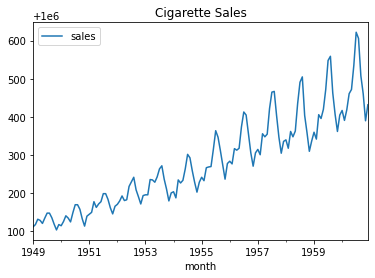

In [15]:
y.plot()
plt.title('Cigarette Sales')
plt.show()

<Figure size 432x288 with 0 Axes>

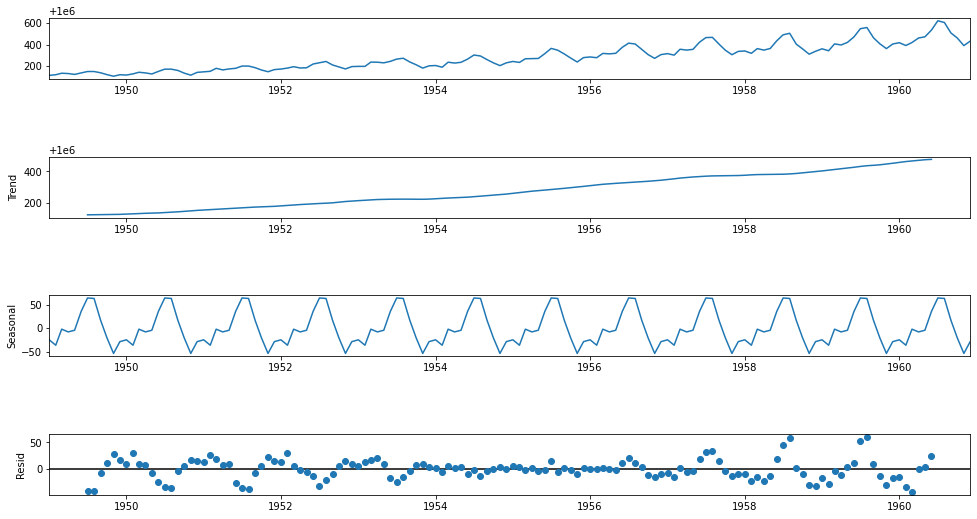

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(y, period=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)
plt.show()

## 3. Modelling 
### 3a. Decomposition
What do you notice from the plot? Take at least `2` minutes to examine the plot, and write down everything you observe.  

All done?

We can see that, generally, there is a trend upwards in cigarette sales from at Cowboy Cigarettes. But there are also some striking - and perhaps unexpected - seasonal fluctuations. These seasonal fluctations come in a repeated pattern. Work out when these seasonal fluctuations are happening, and take 2 minutes to hypothesize on their cause here.

What does it mean to *decompose* time series data? It means breaking that data into 3 components: 

1. **Trend**: The overall direction that the data is travelling in (like upwards or downwards)
2. **Seasonality**: Cyclical patterns in the data 
3. **Noise**: The random variation in the data

We can treat these components differently, depending on the question and what's appropriate in the context. They can either be added together in an *additive* model, or multiplied together in a *multiplicative* model. 

Make a coffee, take `5` minutes and read [this article](https://medium.com/@sigmundojr/seasonality-in-python-additive-or-multiplicative-model-d4b9cf1f48a7) and think about whether our data would conduce to an additive or multiplicative model here. Write your conclusion down just here: 

-------------------------------

All done? Well, just on the basis of the plot above, it seems our Cowboy Cigarettes data is actually multiplicative. 

That's because, as time progresses, the general trend seems to be increasing *at a rate that's also increasing*. We also see that the seasonal fluctuations (the peaks and troughs) get bigger and bigger as time progresses.

Now on the other hand, if the data were simply additive, we could expect the general trend to increase at a *steadily*, and a constant speed; and also for seasonal ups and downs not to increase or decrease in extent over time.

Happily, we can use the `decompose()` function to quantify the component parts described above in our data.

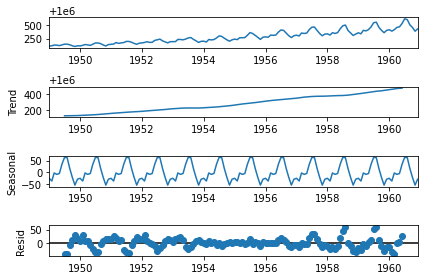

In [22]:
# Plot the original data, the trend, the seasonality, and the residuals 
import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
decomposition.plot()
plt.show()

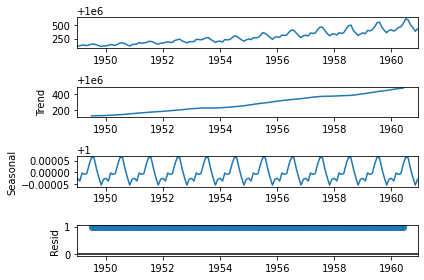

In [23]:
# Plot the original data, the trend, the seasonality, and the residuals 
import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative')
decomposition.plot()
plt.show()

### 3b. Testing for stationarity with KPSS
As you know, when doing time series analysis we always have to check for stationarity. Imprecisely, a time series dataset is stationary just if its statistical features don't change over time. A little more precisely, a stationary time series dataset will have constant mean, variance, and covariance.

There are many ways to test for stationarity, but one of the most common is the KPSS test. The Null hypothesis of this test is that the time series data in question is stationary; hence, if the *p*-value is less than the significance level (typically 0.05, but we decide) then we reject the Null and infer that the data is not stationary.

<div class='alert alert-info'>
    Two statistical tests would be used to check the stationarity of a time series – Augmented Dickey Fuller (“ADF”) test and Kwiatkowski-Phillips-Schmidt-Shin (“KPSS”) test. A method to convert a non-stationary time series into stationary series shall also be used.    
    It is always better to apply both the tests, so that it can be ensured that the series is truly stationary. Possible outcomes of applying these stationary tests are as follows:
    
<ul>
    <li>Case 1: Both tests conclude that the series is not stationary - The series is not stationary</li>
    <li>Case 2: Both tests conclude that the series is stationary - The series is stationary</li>
    <li>Case 3: KPSS indicates stationarity and ADF indicates non-stationarity - The series is trend stationary. Trend needs to be removed to make series strict stationary. The detrended series is checked for stationarity.</li>
    <li>Case 4: KPSS indicates non-stationarity and ADF indicates stationarity - The series is difference stationary. Differencing is to be used to make series stationary. The differenced series is checked for stationarity.</li>
</ul>
</div>

In [25]:
from statsmodels.tsa.stattools import kpss
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [29]:
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [27]:
kpss_test(y)

Results of KPSS Test:
Test Statistic           1.651312
p-value                  0.010000
Lags Used                8.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


/Users/dlc/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1881: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [30]:
adf_test(y)

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


We are in **"Case 4: KPSS indicates non-stationarity and ADF indicates stationarity"** according to the [Statsmodels documentation](https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html) we should do the difference since we need our data to be stationary. So we need to do some transforming.

### 3c. Making the data stationary 
Let's recall what it looks like. 

In [60]:
def plot_time_series(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

def plot_time_series_twin_ax(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    #fig = plt.figure(figsize=(12, 8))
    fig, ax1 = plt.subplots(figsize=(12, 8))
    orig = ax1.plot(timeseries, color='blue',label='Original')
    mean = ax1.plot(rolmean, color='red', label='Rolling Mean')
    plt.legend(loc='best')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    std = ax2.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best', bbox_to_anchor=(0.15,0.92))
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

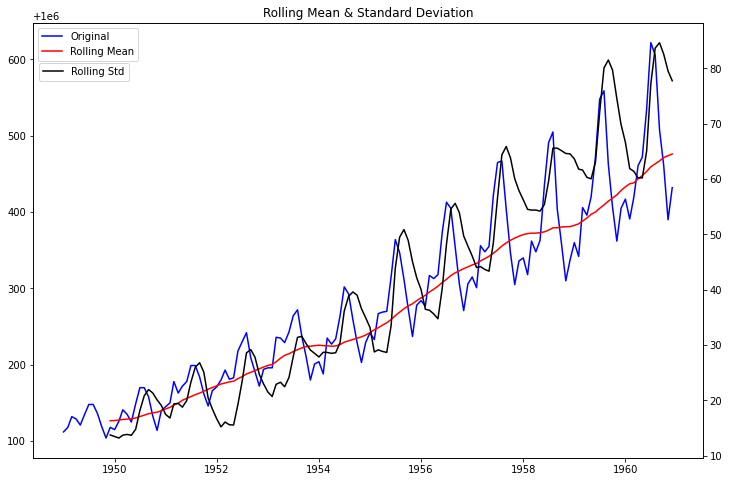

In [61]:
plot_time_series_twin_ax(y)

In our plot, we can see that both the mean and the variance *increase as time progresses*. At the moment, our data has neither a constant mean, nor a constant variance (the covariance, however, seems constant). 

One ofte  used way of getting rid of changing variance is to take the natural log of all the values in our dataset. Let's do this now. 

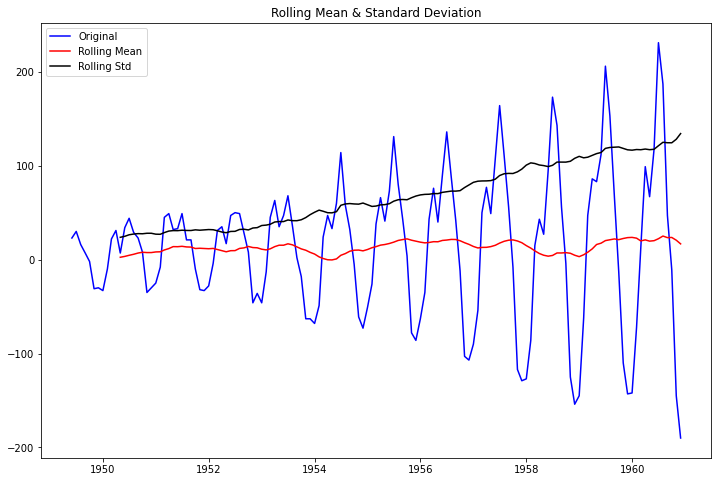

In [99]:
y_diff = y['sales'] - y['sales'].shift(5) # change this number  
plot_time_series(y_diff.dropna(inplace=False)) 


When you plot this, you can see how the variance in our data now remains contant over time.

In [100]:
kpss_test(y_diff.dropna())

Results of KPSS Test:
Test Statistic           0.020438
p-value                  0.100000
Lags Used                5.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


/Users/dlc/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1885: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [101]:
adf_test(y_diff.dropna())

Results of Dickey-Fuller Test:
Test Statistic                  -2.786015
p-value                          0.060299
#Lags Used                      14.000000
Number of Observations Used    124.000000
Critical Value (1%)             -3.484220
Critical Value (5%)             -2.885145
Critical Value (10%)            -2.579359
dtype: float64


Our p-value is now greater than 0.05, so we can accept the null hypothesis that our data is stationary.

### 3d. The ARIMA model

Recall that ARIMA models are based around the idea that it's possible to predict the next value in a time series by using information about the most recent data points. It also assumes there will be some randomness in our data that can't ever be predicted.

We can find some good parameters for our model using the `sklearn` and `statsmodels` libraries, and in particular `mean_squared_error` and `ARIMA`. 

In [102]:
# Import mean_squared_error and ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split

#### 3di. Make a function to find the MSE of a single ARIMA model


In [103]:
# Make a function called evaluate_arima_model to find the MSE of a single ARIMA model 
def arima_model(data, arima_order):
    
    # Needs to be an integer because it is later used as an index. 
    split= int(len(data) * 0.8) 
    
    # Make train and test variables, with 'train, test'
    train, test = data[0:split], data[split:len(data)]
    past=[float(x) for x in train]
    
    # make predictions
    predictions = list()
    for i in range(len(test)):#timestep-wise comparison between test data and one-step prediction ARIMA model. 
        model = ARIMA(past, order=arima_order)
        model_fit = model.fit()
        future = model_fit.forecast()
        predictions.append(future)
        #past.append(test[i])
        
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    
    # Return the error
    return error

#### 3dii. Make a function to evaluate the different ARIMA models with different p, d, and q values

In [ ]:
y_orig = y['sales']

In [110]:
# Make a function to evaluate different ARIMA models with several different p, d, and q values.
arima_model(y_orig.dropna(), arima_order=(1,1,1))

8955.802025896339

In [111]:
arima_model(y_diff.dropna(), arima_order=(1,1,1))

25675.78154615658

In [118]:
# Now, we choose a couple of values to try for each parameter.
# Make a function called evaluate_models to evaluate different ARIMA models with several different p, d, and q values.
def evaluate_models(dataset, p_list, d_list, q_list):
    best_score, best_cfg = float("inf"), None
    # Iterate through p_values
    for p in p_list:
        # Iterate through d_values
        for d in d_list:
            # Iterate through q_values
            for q in q_list:
                # p, d, q iterator variables in that order
                order = (p,d,q)
                try:
                    # Make a variable called mse for the Mean squared error
                    mse = arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    return print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [119]:
# Finally, we can find the optimum ARIMA model for our data.
# Nb. this can take a while...!
p_list = [x for x in range(0, 3)]
d_list = [x for x in range(0, 3)]
q_list = [x for x in range(0, 3)]

In [120]:
# Finally, we can find the optimum ARIMA model for our data.
# Nb. this can take a while...!
import warnings
warnings.filterwarnings("ignore")
evaluate_models(y_diff.dropna(), p_list, d_list, q_list)

ARIMA(0, 0, 0) MSE=14258.324
ARIMA(0, 0, 1) MSE=16682.885
ARIMA(0, 0, 2) MSE=21435.575
ARIMA(0, 1, 0) MSE=32163.750
ARIMA(0, 1, 1) MSE=24804.892
ARIMA(0, 1, 2) MSE=25496.663
ARIMA(0, 2, 0) MSE=25030.179
ARIMA(0, 2, 1) MSE=32458.352
ARIMA(0, 2, 2) MSE=24882.487
ARIMA(1, 0, 0) MSE=26012.332
ARIMA(1, 0, 1) MSE=20462.765
ARIMA(1, 0, 2) MSE=19577.579
ARIMA(1, 1, 0) MSE=29322.357
ARIMA(1, 1, 1) MSE=25675.782
ARIMA(1, 1, 2) MSE=20612.762
ARIMA(1, 2, 0) MSE=30023.109
ARIMA(1, 2, 1) MSE=29379.086
ARIMA(1, 2, 2) MSE=25717.710
ARIMA(2, 0, 0) MSE=19644.073
ARIMA(2, 0, 1) MSE=20277.860
ARIMA(2, 0, 2) MSE=18269.609
ARIMA(2, 1, 0) MSE=25759.257
ARIMA(2, 1, 1) MSE=25420.477
ARIMA(2, 1, 2) MSE=19395.690
ARIMA(2, 2, 0) MSE=31336.770
ARIMA(2, 2, 1) MSE=32931.233
ARIMA(2, 2, 2) MSE=34580.713
Best ARIMA(0, 0, 0) MSE=14258.324


So the best p,d, q, parameters for our ARIMA model are 2, 1, 1 respectively. Now we know this, we can build the model.

In [121]:
p=0
d=0
q=0
model = ARIMA(y_diff.dropna(), order=(p,d,q))
model_fit = model.fit()
forecast = model_fit.forecast(24)

We can take a look at a summary of the model this library has built around our data.

In [122]:
# Call summary() on model_fit
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                  139
Model:                          ARIMA   Log Likelihood                -799.361
Date:                Mon, 23 Nov 2020   AIC                           1602.721
Time:                        08:42:50   BIC                           1608.590
Sample:                    06-01-1949   HQIC                          1605.106
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.8417      6.460      1.988      0.047       0.180      25.503
sigma2      5788.8702    645.915      8.962      0.000    4522.899    7054.841
===================================================================================
Ljung-Box (L1) (Q):                  83.53   Jarque-Bera (JB):                 0.69
Prob(Q):                              0.00   Prob(JB):                         0.71
Heteroskedasticity (H):              13.36   Skew:                            -0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

This [article](https://datascience-george.medium.com/a-brief-introduction-to-arima-and-sarima-modeling-in-python-87a58d375def) from DataScience George says 

<div class='alert alert-info'>
    SARIMAX is used on data sets that have seasonal cycles. The difference between ARIMA and SARIMAX is the seasonality and exogenous factors (seasonality and regular ARIMA don’t mix well). These are a bit complicated, but the key take away is that SARIMAX requires not only the p, d, and q arguments that ARIMA requires, but it also requires another set of p, d, and q arguments for the seasonality aspect as well as an argument called “s” which is the periodicity of the data’s seasonal cycle. 
</div>

In [124]:
import itertools #Grid Search

p = d = q = range(0,3) # p, d, and q can be either 0, 1, or 2
pdq = list(itertools.product(p,d,q)) # gets all possible combinations of p, d, and q 

p2 = d2 = q2 = range(0, 2) # second set of p's, d's, and q's
pdq2 = list(itertools.product(p2,d2,q2)) # simular too code above but for seasonal parameters

s = 12 # here I use twelve but the number here is representative of the periodicty of the seasonal cycle
pdqs2 = [(c[0], c[1], c[2], s) for c in pdq2]
combs = {}
aics = []# Grid Search Continued

for combination in pdq:
    for seasonal_combination in pdqs2:
        try:
            model = sm.tsa.statespace.SARIMAX(y_diff, order=combination, seasonal_order=seasonal_combination,
                                             enforce_stationarity=False,
                                             enforce_invertibility=False)
            model = model.fit()
            combs.update({model.aic : [combination, seasonal_combination]})
            aics.append(model.aic)
            
        except:
            continue
            
best_aic = min(aics)# Modeling and forcasting
model = sm.tsa.statespace.SARIMAX(y_diff, order=combs[best_aic][0], seasonal_order=combs[best_aic][1],
                                             enforce_stationarity=False,
                                             enforce_invertibility=False)
model = model.fit()
model.forecast(7)

1961-01-01   -167.897407
1961-02-01    -89.505394
1961-03-01     10.535245
1961-04-01    104.432358
1961-05-01     77.783038
1961-06-01    124.096004
1961-07-01    230.060977
Freq: MS, Name: predicted_mean, dtype: float64

In [128]:
combs[best_aic]

[(2, 0, 2), (0, 1, 1, 12)]

In [125]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                sales   No. Observations:                  144
Model:             SARIMAX(2, 0, 2)x(0, 1, [1], 12)   Log Likelihood                -472.425
Date:                              Mon, 23 Nov 2020   AIC                            956.849
Time:                                      08:44:41   BIC                            973.422
Sample:                                  01-01-1949   HQIC                           963.578
                                       - 12-01-1960                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0960      0.103     10.607      0.000       0.894       1.299
ar.L2         -0.6146      0.109     -5.614      0.000      -0.829      -0.400
ma.L1         -0.6451      0.072     -8.999      0.000      -0.786      -0.505
ma.L2          0.8387      0.061     13.856      0.000       0.720       0.957
ma.S.L12      -0.0793      0.113     -0.701      0.483      -0.301       0.143
sigma2       187.6674     25.200      7.447      0.000     138.275     237.059
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):                 0.73
Prob(Q):                              0.61   Prob(JB):                         0.69
Heteroskedasticity (H):               2.09   Skew:                             0.17
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 3e. Visualize the results 

Visualize the original dataset plotted against our model. 

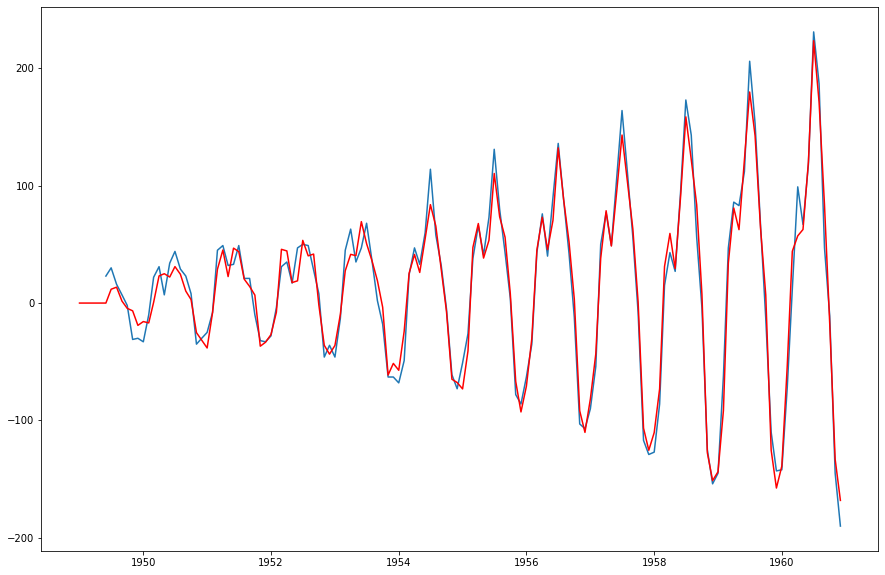

In [129]:
# Call figure() and plot() on the plt
plt.figure(figsize=(15,10))
plt.plot(y_diff.dropna())
plt.plot(model.predict(), color = 'red')

### 3f. Application: Forecasting

We've done well: our model fits pretty closely to our existing data. Let's now use it to forecast what's likely to occur in future.

In [136]:
model.forecast(steps=12)

1961-01-01   -167.897407
1961-02-01    -89.505394
1961-03-01     10.535245
1961-04-01    104.432358
1961-05-01     77.783038
1961-06-01    124.096004
1961-07-01    230.060977
1961-08-01    181.499654
1961-09-01     44.758899
1961-10-01    -13.548913
1961-11-01   -142.683482
1961-12-01   -185.230631
Freq: MS, Name: predicted_mean, dtype: float64

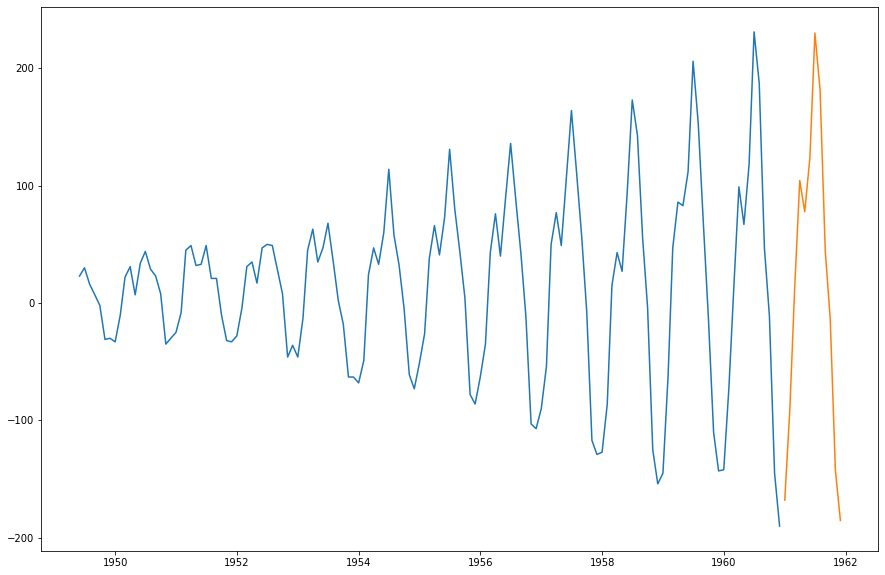

In [135]:

# Declare a variable called forecast_period with the amount of months to forecast, and
# create a range of future dates that is the length of the periods you've chosen to forecast
forecast_period = 10
date_range = pd.date_range(y_diff.dropna().index[-1], periods = forecast_period, 
              freq='MS').strftime("%Y-%m-%d").tolist()

# Convert that range into a dataframe that includes your predictions. First, call DataFrame on pd
future_months = pd.DataFrame(date_range, columns = ['Month'])

# Let's now convert the 'Month' column to a datetime object with to_datetime 
future_months['Month'] = pd.to_datetime(future_months['Month'])
future_months.set_index('Month', inplace = True)
future_months['Prediction'] = forecast[0]

# Plot your future predictions. Call figure() on plt
plt.figure(figsize=(15,10))
plt.plot(y_diff.dropna())
plt.plot(model.forecast(steps=12))
plt.show()

## 4. Evaluating and Concluding

Our model captures the centre of a line that's increasing at a remarkable rate. Cowboy Cigarettes sell more cigarettes in the summer, perhaps due to the good weather, disposable income and time off that people enjoy, and the least in the winter, when people might be spending less and enjoying less free time outdoors. 

Remarkably, our ARIMA model made predictions using just one variable. We can only speculate, however, on the causes of the behaviour predicted by our model. We should also take heed that spikes in data, due to sudden unusual circumstances like wars, are not handled well by ARIMA; and the outbreak of the Vietnam War in the 1960s would likely cause our model some distress.  

We could suggest to our employers that, if they are interested in discovering the causes of the cigarette sales trajectory, they execute a regression analysis in addition to the time series one. 